<a href="https://colab.research.google.com/github/elliotgengler/Option-DeAmericanization/blob/main/BBSR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import math
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from scipy.stats import norm

# Binomial Black Scholes (BBS) Method

In [14]:
def digits_right(guess,actual):
  return -math.log10(abs(guess-actual))

def print_eval(est,actual,start,stop,prec):
  print("Estimate:",round(est,prec))
  print("Error:",round(actual-est,prec))
  print("Digits Correct:",round(digits_right(est,actual),2))
  print("Time Elapsed (s):", round(stop-start,4))

# ran for ~50s to get a very good estimate:
# exact_am = bbsr(S_0=100,K=100,Maturity=1,sigma=0.2,r=0.05,q=0.02,N=100000,is_call=False)
exact_am = 6.6606863881632155

In [15]:
def p_riskneutral(r,q,delta_time,u,d):
  return (math.exp((r-q)*delta_time)-d)/(u-d)

def black_scholes(S_0,K,T,sigma,r,q,is_call):
  d1 = (np.log(S_0/K)+(r-q+sigma**2/2)*T)/(sigma*math.sqrt(T))
  d2 = d1 - sigma*math.sqrt(T)
  if is_call:
    return(S_0*math.exp(-q*T)*norm.cdf(d1) - K*math.exp(-r*T)*norm.cdf(d2))
  else:
    return(K*math.exp(-r*T)*norm.cdf(-d2) - S_0*math.exp(-q*T)*norm.cdf(-d1))

def backward_induce(V,S,u,pstar,disc,K,is_call,use_bs,params,is_american):
  # perform one step of backward induction on state vectors V and S
  # Stock Update:
  S = S[:-1]*u

  # Determine Continuing Value
  if use_bs:
    delta,sigma,r,q = params
    continuing_val = black_scholes(S,K,delta,sigma,r,q,is_call)
  else:
    # otherwise use risk-neutral expectation of future prices
    continuing_val = (pstar * V[1:] + (1-pstar) * V[:-1]) * disc

  if is_american:
    # Excercise Value (when relevant)
    if is_call:
      exercise_val = np.maximum(S-K,np.zeros(S.shape[0])) * disc
    else:
      exercise_val = np.maximum(K-S,np.zeros(S.shape[0])) * disc
    V = np.maximum(continuing_val,exercise_val)
  else:
    V = continuing_val
  return V, S

def binomial_black_scholes(S_0,K,T,sigma,r,q,N,is_call,is_american):
  delta = T/N # time step
  u = math.exp(sigma*math.sqrt(delta)) # CRR Assumptions
  d = 1/u

  pstar = p_riskneutral(r,q,delta,u,d) # risk neutral probability of up
  disc = math.exp(-r*delta) # discount per time step

  i = np.arange(N+1)
  S = S_0*u**(i)*d**(N-i) # initialize stock price range
  V = np.zeros(N+1) # initialize value array

  # start with Black Scholes prices (instead of payoffs)
  V,S = backward_induce(V,S,u,pstar,disc,K,is_call,True,(delta,sigma,r,q),is_american)

  for i in range(N-1):
    # and N - 1 rounds of typical backward induction
    V,S = backward_induce(V,S,u,pstar,disc,K,is_call,False,(),is_american)
  return V[0]

In [16]:
start = time.time()
est = binomial_black_scholes(S_0=100,K=100,T=1,sigma=0.2,r=0.05,q=0.02,N=1000,is_call=False,is_american=True)
stop = time.time()

print_eval(est,exact_am,start,stop,8)

Estimate: 6.66111376
Error: -0.00042737
Digits Correct: 3.37
Time Elapsed (s): 0.0187


# Richardson Extrapolation (BBSR)

In [17]:
def bbsr(S_0,K,T,sigma,r,q,N,is_call,is_american):
  if N%2 != 0:
    raise ValueError("N must be even")
  C1 = binomial_black_scholes(S_0,K,T,sigma,r,q,N//2,is_call,is_american)
  C2 = binomial_black_scholes(S_0,K,T,sigma,r,q,N,   is_call,is_american)
  return 2*C2 - C1

In [18]:
start = time.time()
est = bbsr(S_0=100,K=100,T=1,sigma=0.2,r=0.05,q=0.02,N=1000,is_call=False,is_american=True)
stop = time.time()

print_eval(est,exact_am,start,stop,8)

Estimate: 6.66073825
Error: -5.186e-05
Digits Correct: 4.29
Time Elapsed (s): 0.0402


# CRR w/ Backward Induction

Code from the first pricer. Here for comparison.

In [19]:
def payoff(S_0,N,j,u,d,K,is_call):
  S_t = S_0 * u**j * d**(N-j) # up j times, down N-j times
  if is_call:
    return np.maximum(S_t-K,0)
  else:
    return np.maximum(K-S_t,0)

def crr_backward_induction(S_0,K,T,sigma,N,r,q,is_call,is_american):
  delta = T/N
  u = math.exp(sigma*math.sqrt(delta))
  d = math.exp(-sigma*math.sqrt(delta))

  pstar = p_riskneutral(r,q,delta,u,d) # risk neutral probability of up
  disc = math.exp(-r*delta) # discount per time step

  i = np.arange(N+1)
  V = payoff(S_0,N,i,u,d,K,is_call) # initialize payoffs at maturity
  S = S_0*u**(i)*d**(N-i) # initialize stock price range at maturity

  for i in range(N):
    # N rounds of backward induction
    V,S = backward_induce(V,S,u,pstar,disc,K,is_call,False,(),is_american)
  return V[0]

# Performance

In [20]:
errors_crr = []
runtimes_crr = []

for i in range(1,1001):
  start = time.time()
  est = crr_backward_induction(S_0=100,K=100,T=1,sigma=0.2,N=i,r=0.05,q=0.02,is_call=False,is_american=True)
  stop = time.time()

  errors_crr.append(est-exact_am)
  runtimes_crr.append(stop-start)

In [21]:
errors_bbs = []
runtimes_bbs = []

for i in range(1,1001):
  start = time.time()
  est = binomial_black_scholes(S_0=100,K=100,T=1,sigma=0.2,r=0.05,q=0.02,N=i,is_call=False,is_american=True)
  stop = time.time()

  errors_bbs.append(est-exact_am)
  runtimes_bbs.append(stop-start)

In [22]:
errors_bbsr = []
runtimes_bbsr = []

for i in range(2,1001,2):
  start = time.time()
  est = bbsr(S_0=100,K=100,T=1,sigma=0.2,r=0.05,q=0.02,N=i,is_call=False,is_american=True)
  stop = time.time()

  errors_bbsr.append(est-exact_am)
  runtimes_bbsr.append(stop-start)

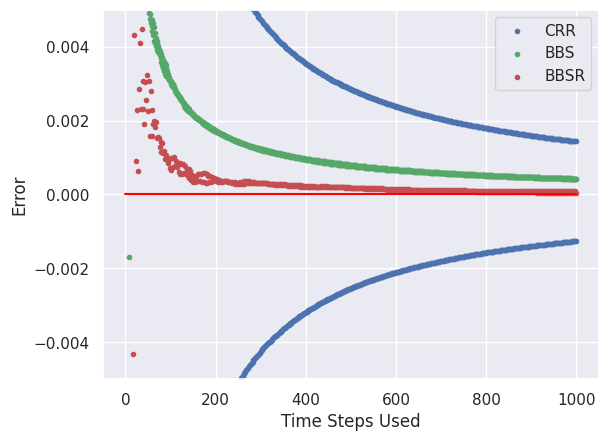

In [23]:
plt.scatter(range(1,1001),errors_crr,marker='.',label='CRR',color='b')
plt.scatter(range(1,1001),errors_bbs,marker='.',label='BBS',color='g')
plt.scatter(range(2,1001,2),errors_bbsr,marker='.',label="BBSR",color='r')
plt.plot(np.zeros(1000),color='red')
plt.ylim([-0.005,0.005])
plt.xlabel("Time Steps Used")
plt.ylabel("Error")
plt.legend()
plt.show()

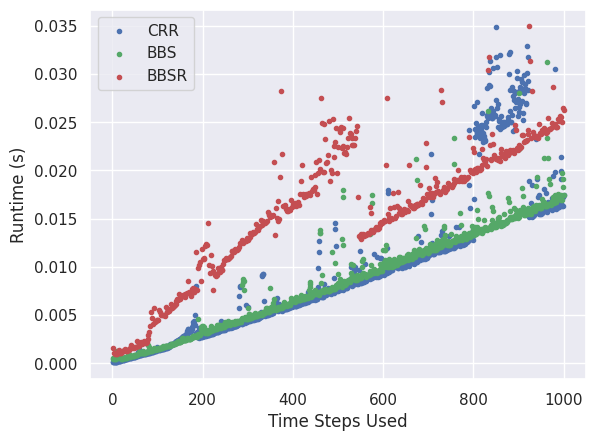

In [24]:
plt.scatter(range(1,1001),runtimes_crr,marker='.',label='CRR',color='b')
plt.scatter(range(1,1001),runtimes_bbs,marker='.',label='BBS',color='g')
plt.scatter(range(2,1001,2),runtimes_bbsr,marker='.',label="BBSR",color='r')
plt.xlabel("Time Steps Used")
plt.ylabel("Runtime (s)")
plt.legend()
plt.show()